Create a simple 2-class classification task (non-linear boundary)

Try 2 models:
Underfit Model: Too simple
Overfit Model: Too complex on small data

In [193]:
import torch

import numpy as np

import torch.nn as nn

import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.datasets import make_moons

from sklearn.model_selection import train_test_split

In [194]:
# Generate synthetic non-linear data

X,y = make_moons(n_samples=300, noise=0.25, random_state=42)

X = torch.tensor(X, dtype=torch.float32)

y = torch.tensor(y.reshape(-1,1), dtype=torch.float32)

In [195]:
# Split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

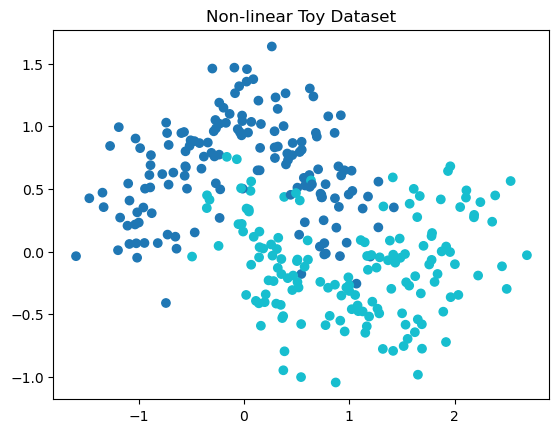

In [196]:
# Plot data

plt.scatter(X[:,0], X[:,1], c=y[:,0], cmap='tab10')

plt.title("Non-linear Toy Dataset")

plt.show()

🤏 Model 1: Underfitting

In [197]:
class UnderfitNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.fc = nn.Linear(2,1) # Just a linear model

    def forward(self,x):

        return torch.sigmoid(self.fc(x))

In [198]:
underfit_model = UnderfitNet()

loss_fn = nn.BCELoss()

optimizer = optim.SGD(underfit_model.parameters(), lr=0.1)

In [199]:
train_loss , val_loss = [], []


for epoch in range(100):

    # Forward pass

    preds = underfit_model(X_train)

    loss = loss_fn(preds, y_train)

    # Backward + update

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    # Track

    train_loss.append(loss.item())

    with torch.no_grad():

        val_preds = underfit_model(X_val)

        val_loss.append(loss_fn(val_preds, y_val).item())

🧠 Model 2: Overfitting

In [200]:
class OverfitNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(

            nn.Linear(2,64),

            nn.ReLU(),

             nn.Linear(64,64),

            nn.ReLU(),

            nn.Linear(64,1),

            nn.Sigmoid()
        )


    def forward(self, x):

        return self.net(x)

In [201]:
overfit_model = OverfitNet()

optimizer2 = optim.Adam(overfit_model.parameters(), lr=0.01)

In [202]:
train_loss2, val_loss2 = [], []

for epoch in range(100):

    preds = overfit_model(X_train)

    loss = loss_fn(preds, y_train)


    optimizer2.zero_grad()

    loss.backward()

    optimizer2.step()


    train_loss2.append(loss.item())

    with torch.no_grad():

        val_preds = overfit_model(X_val)

        val_loss2.append(loss_fn(val_preds, y_val).item())

Plot Loss Curves

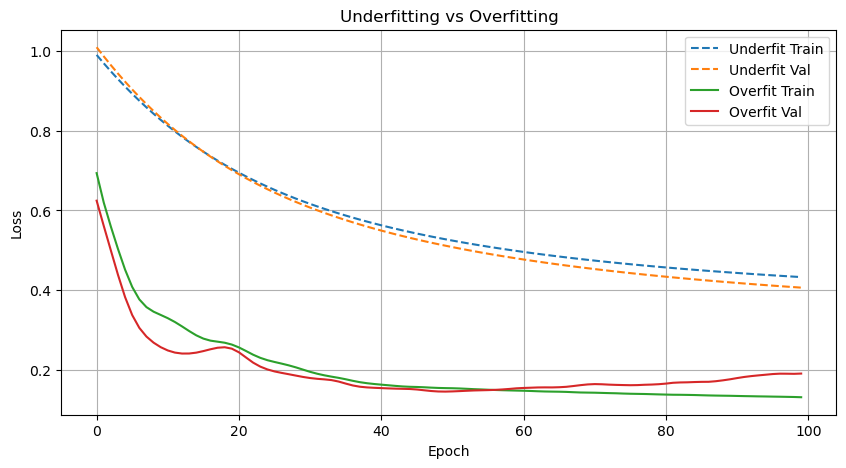

In [203]:
plt.figure(figsize=(10,5))


plt.plot(train_loss, label='Underfit Train', linestyle='dashed')

plt.plot(val_loss, label='Underfit Val', linestyle='dashed')


plt.plot(train_loss2, label='Overfit Train')

plt.plot(val_loss2, label='Overfit Val')


plt.title('Underfitting vs Overfitting')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()

plt.grid(True)

plt.show()

This will give you a clear picture of both underfitting and overfitting:

🔴 Underfit: Both losses stay high
🔵 Overfit: Train loss goes down, val loss increases

Add L2 Regularization (a.k.a. Weight Decay)

In [204]:
overfit_model_l2 = OverfitNet()

optimizer_l2 = optim.Adam(overfit_model_l2.parameters(), lr=0.01, weight_decay=0.01)  # ← L2 added

In [205]:
train_loss_l2, val_loss_l2 = [], []

for epoch in range(100):

    preds = overfit_model_l2(X_train)

    loss = loss_fn(preds, y_train)


    optimizer_l2.zero_grad()

    loss.backward()

    optimizer_l2.step()


    train_loss_l2.append(loss.item())

    with torch.no_grad():

        val_preds = overfit_model_l2(X_val)

        val_loss_l2.append(loss_fn(val_preds, y_val).item())

Add Dropout in the Network

🧠 Model with Dropout

In [206]:
class DropoutNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(2,64),
            nn.ReLU(),
            nn.Dropout(0.3), # ← Dropout added
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64,1),
            nn.Sigmoid()
        )

    def forward(self,x):

        return self.net(x)

In [207]:
dropout_model = DropoutNet()

optimizer_dropout = optim.Adam(dropout_model.parameters(), lr=0.01)

In [208]:
train_loss_do , val_loss_do = [], []

for epoch in range(100):

    preds = dropout_model(X_train)

    loss = loss_fn(preds, y_train)


    optimizer_dropout.zero_grad()

    loss.backward()

    optimizer_dropout.step()


    train_loss_do.append(loss.item())

    with torch.no_grad():

        val_preds = dropout_model(X_val)

        val_loss_do.append(loss_fn(val_preds, y_val).item())

Compare All Variants

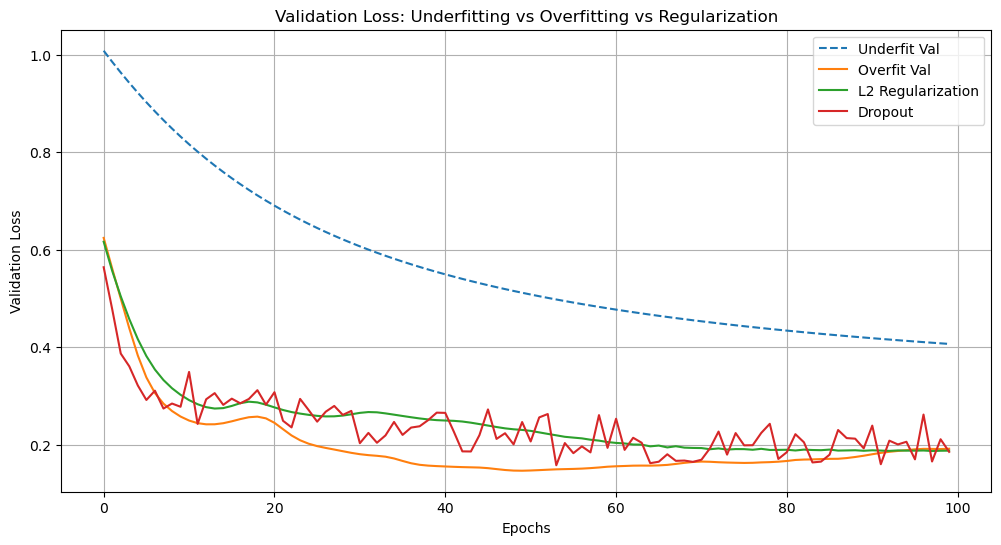

In [209]:
plt.figure(figsize=(12,6))


plt.plot(val_loss, label='Underfit Val', linestyle='dashed')

plt.plot(val_loss2, label='Overfit Val')


plt.plot(val_loss_l2, label='L2 Regularization')

plt.plot(val_loss_do, label='Dropout')


plt.title("Validation Loss: Underfitting vs Overfitting vs Regularization")

plt.xlabel("Epochs")

plt.ylabel("Validation Loss")

plt.legend()

plt.grid(True)

plt.show()

You should see how L2 and Dropout reduce overfitting — smoother validation loss and better generalization.

Visualize Decision Boundary

In [210]:
def plot_decision_boundary(model, X,y, title):

    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5

    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)


    with torch.no_grad():

        preds = model(grid).reshape(xx.shape)

    
    plt.contourf(xx, yy, preds, levels=50, cmap='tab10', alpha=0.6)

    plt.scatter(X[:,0], X[:,1], c=y[:,0],cmap='tab10', edgecolors='k')

    plt.title(title)

    plt.show()

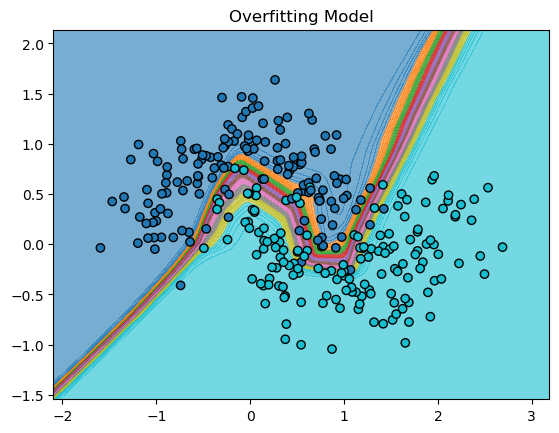

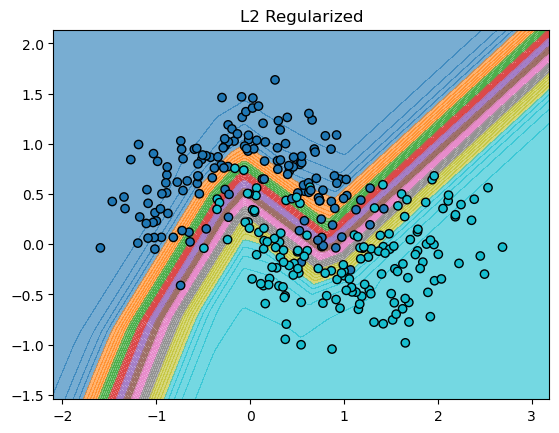

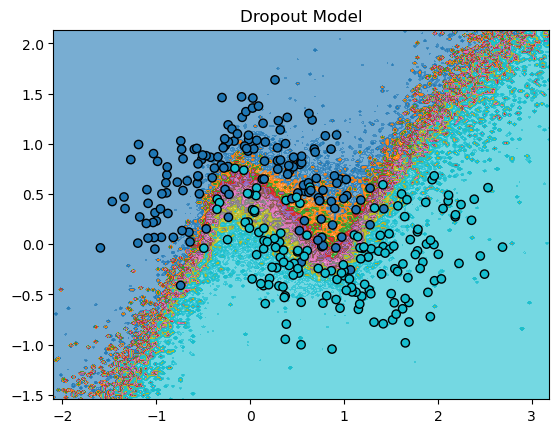

In [211]:
plot_decision_boundary(overfit_model, X,y, 'Overfitting Model')

plot_decision_boundary(overfit_model_l2, X,y, 'L2 Regularized')

plot_decision_boundary(dropout_model, X,y, 'Dropout Model')